In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader( testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


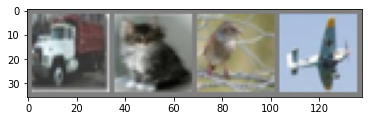

truck   cat  bird plane


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layer = nn.Sequential(

            # 1st block of CNN layer
            # number of pixels = 32
            nn.Conv2d(3,32,3,1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32,64,3,1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            # number of pixel after 2,2 pool = 32/2 = 16

            # 2nd block of CNN layer
            # number of pixels = 16
            nn.Conv2d(64, 128, 3, 1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            # number of pixel after 2,2 pool = 16/2 = 8
            nn.Dropout2d(p=0.05),

            # 3rd block of CNN layer
            # number of pixels = 8
            nn.Conv2d(128, 256, 3, 1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # number of pixel after 2,2 pool = 8/2 = 4

            # 4th block of CNN layer
            # number of pixels = 4
            nn.Conv2d(256, 512, 3, 1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # number of pixel after 2,2 pool = 4/2 = 2
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        #covolutional layers
        x = self.conv_layer(x)
        #view flatten
        x = x.view(x.size(0), -1)
        #fully connected layers
        x = self.fc_layer(x)

        return x

net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [16]:
def net_accuracy(accuracy_on_data, class_acc, net_acc, plt_no):

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in accuracy_on_data:
            images, labels = data[0].to(device), data[1].to(device)
            #images = images.view(4, -1)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            c_sum = (predicted == labels).sum().item()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    total_correct = 0
    total_classes = 0
    for i in range(10):
        total_correct += class_correct[i]
        total_classes += class_total[i]
        accuracy_perc = 100 * class_correct[i] / class_total[i]
        #print('Accuracy of %5s : %2d %%' % (
              #classes[i], accuracy_perc))
        class_acc.append(accuracy_perc)

    cnn_accuracy = 100 * total_correct / total_classes
    net_acc.append(cnn_accuracy)
    if accuracy_on_data == testloader:
        print('\nTotal Accuracy for Test Data @ %1d Epoch = %2d %%' %(epoch+1 , cnn_accuracy))
    else:
        print('\nTotal Accuracy for Train Data @ %1d Epoch = %2d %%' %(epoch+1 , cnn_accuracy))
    
    plt.figure(num=plt_no)
    if accuracy_on_data == testloader:
        plt.title('Classwise Network Accuracy on test data')
    else:
        plt.title('Classwise Network Accuracy on train data')

    plt.plot(list(classes), class_acc, label=('Epoch: %1d' %(epoch+1)))
    # Put a legend to the right of the current axis
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.xlabel('Class Name')
    plt.ylabel('Class Accuracy %')


  0%|          | 0/15 [00:00<?, ?it/s]


Total Accuracy for Train Data @ 1 Epoch = 60 %



  7%|▋         | 1/15 [02:29<34:59, 149.95s/it]


Total Accuracy for Test Data @ 1 Epoch = 59 %

Total Accuracy for Train Data @ 2 Epoch = 68 %



 13%|█▎        | 2/15 [04:59<32:29, 149.94s/it]


Total Accuracy for Test Data @ 2 Epoch = 66 %

Total Accuracy for Train Data @ 3 Epoch = 78 %



 20%|██        | 3/15 [07:30<30:00, 150.05s/it]


Total Accuracy for Test Data @ 3 Epoch = 74 %

Total Accuracy for Train Data @ 4 Epoch = 83 %



 27%|██▋       | 4/15 [09:59<27:27, 149.80s/it]


Total Accuracy for Test Data @ 4 Epoch = 78 %

Total Accuracy for Train Data @ 5 Epoch = 84 %



 33%|███▎      | 5/15 [12:30<25:02, 150.21s/it]


Total Accuracy for Test Data @ 5 Epoch = 78 %

Total Accuracy for Train Data @ 6 Epoch = 86 %



 40%|████      | 6/15 [15:00<22:31, 150.13s/it]


Total Accuracy for Test Data @ 6 Epoch = 79 %

Total Accuracy for Train Data @ 7 Epoch = 88 %



 47%|████▋     | 7/15 [17:31<20:04, 150.53s/it]


Total Accuracy for Test Data @ 7 Epoch = 80 %

Total Accuracy for Train Data @ 8 Epoch = 89 %



 53%|█████▎    | 8/15 [20:02<17:33, 150.55s/it]


Total Accuracy for Test Data @ 8 Epoch = 80 %

Total Accuracy for Train Data @ 9 Epoch = 90 %



 60%|██████    | 9/15 [22:31<15:01, 150.18s/it]


Total Accuracy for Test Data @ 9 Epoch = 81 %

Total Accuracy for Train Data @ 10 Epoch = 92 %



 67%|██████▋   | 10/15 [25:02<12:31, 150.20s/it]


Total Accuracy for Test Data @ 10 Epoch = 82 %

Total Accuracy for Train Data @ 11 Epoch = 95 %



 73%|███████▎  | 11/15 [27:31<09:59, 149.96s/it]


Total Accuracy for Test Data @ 11 Epoch = 83 %

Total Accuracy for Train Data @ 12 Epoch = 93 %



 80%|████████  | 12/15 [30:00<07:28, 149.63s/it]


Total Accuracy for Test Data @ 12 Epoch = 81 %

Total Accuracy for Train Data @ 13 Epoch = 95 %



 87%|████████▋ | 13/15 [32:29<04:58, 149.34s/it]


Total Accuracy for Test Data @ 13 Epoch = 82 %

Total Accuracy for Train Data @ 14 Epoch = 96 %



 93%|█████████▎| 14/15 [35:00<02:29, 149.96s/it]


Total Accuracy for Test Data @ 14 Epoch = 82 %

Total Accuracy for Train Data @ 15 Epoch = 96 %



100%|██████████| 15/15 [37:32<00:00, 150.18s/it]


Total Accuracy for Test Data @ 15 Epoch = 83 %
Finished Training


Text(0, 0.5, 'Total Network Accuracy %')

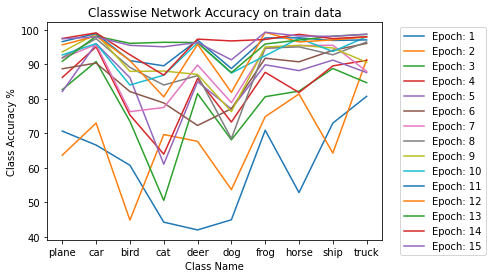

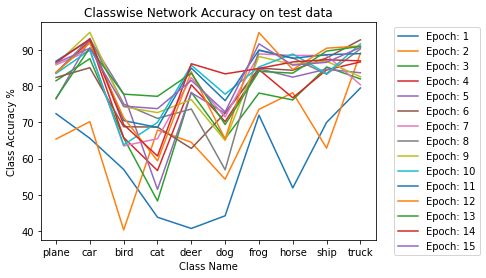

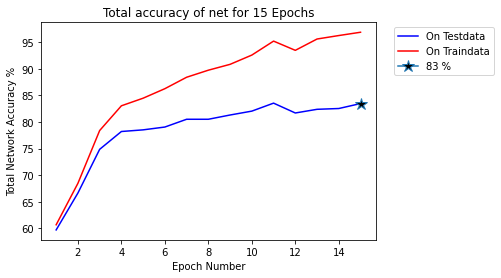

In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
learn_rate = 0.001
optimizer = optim.SGD(net.parameters(), lr=learn_rate, momentum=0.9)

total_net_acc_test = []
total_net_acc_train = []
epoch_list = []

for epoch in tqdm(range(15)):  # loop over the dataset multiple times

    trainset_acc = []
    testset_acc =[]
    epoch_list.append(epoch+1)

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]

        inputs, labels = data[0].to(device), data[1].to(device)
        #inputs = inputs.view(4,-1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            #print('[%d, %5d] loss: %.3f' %
                  #(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    net_accuracy(trainloader, trainset_acc, total_net_acc_train, 1)
    net_accuracy(testloader, testset_acc, total_net_acc_test, 2)

print('Finished Training')

plt.figure(num=3)
for i in range(2):
    if i ==0:
        plt.plot(epoch_list, total_net_acc_test, 'b', label='On Testdata')
    else:
        plt.plot(epoch_list, total_net_acc_train, 'r', label='On Traindata')
plt.plot(epoch_list[-1], total_net_acc_test[-1], marker='*', markersize=12,
          mfc='black', label=('%2d %%' %(total_net_acc_test[-1])))
plt.title('Total accuracy of net for %1d Epochs' %(len(epoch_list)))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel('Epoch Number')
plt.ylabel('Total Network Accuracy %')